## Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio
from scipy.optimize import minimize
from scipy.special import huber

# Homework 4: robotic navigation

**Preamble**: You have built a robot for navigating in an indoor environment. The environments you consider have flat floors, so that the whole task is always two-dimensional. The robot has a sensing capability, as it can sense a location with respect to special beacons. You have given a robot to a friend, who uses it to map different interiors. To do the mapping, your friend places beacons at the perimeter of the interior, and then moves the robot through some trajectory.
Every so often the robot stops, uses its compass to align itself with the direction to the north and then tries to sense the location of the beacons (relative to the robot's current position). Typically, it manages to locate several closest beacons. Your friend has conducted three experiments in three different interiors. You need to recover the location of beacons and the locations of the robot (where the measurements have been taken). 
From each experiment you get four arrays of measurements: **'beacons', 'robots', 'x', 'y'**. It is interpreted as follows: while the robot is in the position number **'robots[i]'**, it senses the beacon number **'beacons(i)'**, and the beacon is displaced by **'x[i]'** and **'y[i]'** from the robot's position. For each robot position, the robot senses several beacons. This data should be sufficient to recover the positions of the robot and of the beacons (up to a global translation, that does not matter for the purposes of your friend). 

**Experiment one (task1.mat) - 1 point:** This is the simplest environment (a room with a simple shape), the robot sensor works well (although a certain amount of Gaussian noise is present). The reconstruction can be reduced to solving a simple least-squares problem. Hint: use linear least-squares. Avoid using the explicit inversion of matrix. Instead, use *numpy.linalg.lstsq* to solve equations. Note that *numpy.linalg.lstsq* might add a (small) regularization to the system. Try using inversion (*'numpy.linalg.inv'*) to see how the reconstruction performs without regularization.


### Solution

Let us fix some reference system on our plane with y-axis oriented to the north. If the robot, while moving in the room, stops, he sends coordinate of some beacon in his own reference system. Let $(\hat{X}_{\text{b[i]}},\hat{Y}_{\text{b[i]}})$ and $(\tilde{X}_{\text{r[i]}},\tilde{Y}_{\text{r[i]}})$ be coordinates in our fixed reference system of the beacon number **beacons[i]** and the robot position number **robots[i]**. Then according to robot's moving reference system, we can write down following equations:

$$
\begin{cases}
\hat{X}_{\text{b[i]}} = \tilde{X}_{\text{r[i]}} + x_{\text{[i]}}, \\
\hat{Y}_{\text{b[i]}} = \tilde{Y}_{\text{r[i]}} + y_{\text{[i]}}.
\end{cases}
\Leftrightarrow
\begin{cases}
\hat{X}_{\text{b[i]}} - \tilde{X}_{\text{r[i]}} = x_{\text{[i]}}, \\
\hat{Y}_{\text{b[i]}} - \tilde{Y}_{\text{r[i]}} = y_{\text{[i]}}.
\end{cases}
~i = 1, \dots, N
$$

We have got a system of equations but $X$ and $Y$ are independent in it (there are no equations with both components of $X$ and $Y$ in them). So, we can solve separately system with only $X$ and analogically system with only $Y$.

Let us write down our system in matrix form: 

$$
AX=x,~A \in \mathbb{R}^{N\times(B+R)},~X \in \mathbb{R}^{(B+R)\times 1},~x \in \mathbb{R}^{N\times 1}
$$

where matrix $A$ is the following matrix:

$$
\begin{cases}
A_{ij}=1, \text{if beacons[i]=j}, \\
A_{i(j+B)}=-1, \text{if robots[i]=j}, \\
A_{ij}=0, \text{otherwise}.
\end{cases}
$$

In [2]:
class RoboticNavigation(object):
    
    def __init__(self, mat_contents):
        """Class for robotic navigation problem."""
        
        self.beacons = np.reshape(mat_contents['beacons'], -1)-1
        self.robots = np.reshape(mat_contents['robots'], -1)-1
        self.x = np.reshape(mat_contents['x'], -1)
        self.y = np.reshape(mat_contents['y'], -1)
        self.B = self.beacons.max()+1
        self.R = self.robots.max()+1
        self.N = self.beacons.size
        
        self.A = np.zeros((2*self.N, 2*self.B+3*self.R))
        for i in xrange(self.N):
            self.A[i][self.beacons[i]] = 1
            self.A[i][self.B+self.robots[i]] = -1
            self.A[self.N+i][self.B+self.R+self.beacons[i]] = 1
            self.A[self.N+i][2*self.B+self.R+self.robots[i]] = -1
     
    def simple_reconstruct(self):
        """Reconstruct beacons and robot positions in the simplest case."""
        
        beacons, robots, x, y, B, R, N = self.beacons, self.robots, self.x, self.y, self.B, self.R, self.N

        A = self.A[:N,:(R+B)]

        X = np.linalg.lstsq(A,x)[0]
        X = X - X.min()
        Y = np.linalg.lstsq(A,y)[0]
        Y = Y - Y.min()
        
        sol = X[:B], X[B:B+R], Y[:B], Y[B:B+R], np.zeros(R)
        return sol
    
    def inv_reconstruct(self):
        """Reconstruct beacons and robot positions using pseudo-inverse of a matrix."""
        
        beacons, robots, x, y, B, R, N = self.beacons, self.robots, self.x, self.y, self.B, self.R, self.N
        A = self.A[:N,:(R+B)]    
        
        A_inv = np.linalg.pinv(A)
        
        X = A_inv.dot(x)
        Y = A_inv.dot(y)
        
        sol = X[:B], X[B:B+R], Y[:B], Y[B:B+R], np.zeros(R)
        return sol
    
    def visualize(self, sol, loc='best'):
        """Visualize restored beacons and robots positions."""
        
        plt.scatter(sol[0], sol[2], c='black', label='beacons', s=100)
        plt.scatter(sol[1], sol[3], c='red', label='robots',s=100)
        plt.legend(loc=loc)
        plt.show()

##### numpy.linalg.lstsq

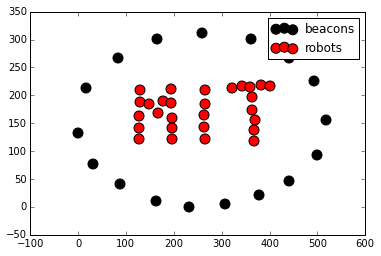

In [3]:
mat_contents = sio.loadmat('task1.mat')
rn = RoboticNavigation(mat_contents)
sol = rn.simple_reconstruct()
rn.visualize(sol)

##### numpy.linalg.pinv

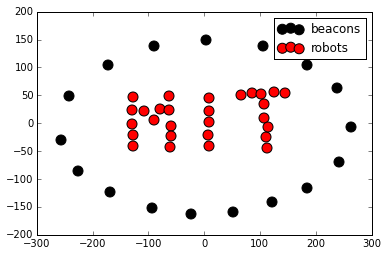

In [4]:
mat_contents = sio.loadmat('task1.mat')
rn = RoboticNavigation(mat_contents)
sol = rn.inv_reconstruct()
rn.visualize(sol)

** Experiment two (task2.mat) - 4 points: ** This is a more complex environment. On top of that, there are strong electrical currents under the floor, so that the compass on the robot makes significant errors, so that the robot is not perfectly oriented. Thus, in addition to robot positions you would also need to recover robot orientations. *Hint and instructions:* you can still try to solve the problem as if the robot is perfectly oriented. You can then use what you obtain as an initialization to the non-linear initialization (angles can be initialized at zero). For the non-linear optimization, you should use non-linear least-squares. You can then either code Levenberg-Marquardt method yourself or figure out how to use *'scipy.optimize'*. In the latter case, to get the points, your final version must provide the python's routine with a Jacobian computed (analytically) by your code.


### Solution

Let $\theta_{\text{r[i]}}$ be the angle between the East and x-axis of robot's own disoriented reference system. If robot tells us that coordinates of the beacon $\text{b[i]}$ are $x_\text{[i]}$ and $y_\text{[i]}$ than real coordinates can be obtained through the inverse of rotation matrix. Our system from the previous task will be rewritten in the following way:

$$
\begin{pmatrix} \hat{X}_{\text{b[i]}} \\ \hat{Y}_{\text{b[i]}} \end{pmatrix} = 
\begin{pmatrix} \tilde{X}_{\text{r[i]}} \\ \tilde{Y}_{\text{r[i]}} \end{pmatrix} + 
\begin{pmatrix} \cos\theta_{\text{r[i]}} & -\sin \theta_{\text{r[i]}}\\ \sin \theta_{\text{r[i]}} & \cos \theta_{\text{r[i]}}\end{pmatrix} \begin{pmatrix} x_{\text{[i]}} \\ y_{\text{[i]}} \end{pmatrix}
$$

Now our task is to minimize non-linear vector-function $F(\hat{X},\tilde{X},\hat{Y},\tilde{Y},\theta)$ of size $2N$:

$$
F_i = \hat{X}_{\text{b[i]}} - \tilde{X}_{\text{r[i]}} - x_{\text{[i]}} \cos\theta_{\text{r[i]}} + y_{\text{[i]}} \sin \theta_{\text{r[i]}},~i = 1,\dots,N \\
F_i = \hat{Y}_{\text{b[i]}} - \tilde{Y}_{\text{r[i]}} - x_{\text{[i]}} \sin \theta_{\text{r[i]}} - y_{\text{[i]}} \cos\theta_{\text{r[i]}},~i = N+1,\dots,2N
$$

which can be done by Levenberg-Marquardt iteration algorithm:

$$
[J^T(x_k)J(x) + \lambda_k I]p_k = -J^T(x_k)F(x_k), \\
x_{k+1} = x_k + p_k.
$$

The only remaining thing to do is to calculate Jacobian $J(x_k)$ of our function $F$ in point $x_k = (\hat{X},\tilde{X},\hat{Y},\tilde{Y},\theta)$. It can be easily done if we look at our function $F$. We do not present here these calculations, however they are implemented in structure of the matrix **A** and in function **jacobian**.

In [5]:
class RoboticNavigation2(RoboticNavigation):
    
    def __init__(self, mat_contents):    
        super(RoboticNavigation2, self).__init__(mat_contents)
        
    def jacobian(self, X):   
        """Calculate jacobian of vector-function F."""
        
        beacons, robots, x, y, B, R, N = self.beacons, self.robots, self.x, self.y, self.B, self.R, self.N
        
        J = np.copy(self.A)
        for i in xrange(N):
            theta = X[2*B+2*R+robots[i]]
            J[i][2*B+2*R+robots[i]] = x[i]*np.sin(theta) + y[i]*np.cos(theta)
            J[N+i][2*B+2*R+robots[i]] = -x[i]*np.cos(theta) + y[i]*np.sin(theta)        
        return J

    def vector_function(self, X):
        """Calculate vector-function F."""
        
        beacons, robots, x, y, B, R, N = self.beacons, self.robots, self.x, self.y, self.B, self.R, self.N
        
        F = np.zeros(2*N)
        for i in xrange(N):
            theta = X[2*B+2*R+robots[i]]
            F[i] = X[beacons[i]] - X[B+robots[i]] - x[i]*np.cos(theta) + y[i]*np.sin(theta)
            F[N+i] = X[B+R+beacons[i]] - X[2*B+R+robots[i]] - x[i]*np.sin(theta) - y[i]*np.cos(theta)
        return F
    
    def levenberg_marquardt(self, MAX_ITER = 20):
        """Levenberg-Marquardt method for beacons and robot positions reconstruction when robot is not perfectly oriented."""
        
        beacons, robots, x, y, B, R, N = self.beacons, self.robots, self.x, self.y, self.B, self.R, self.N
        
        sol = self.simple_reconstruct()
        init = np.concatenate(sol)
        X = init

        for i in xrange(MAX_ITER):
            J = self.jacobian(X) 
            F = self.vector_function(X)
            left = (J.T).dot(J)
            left = left + 0.005*np.identity(left.shape[0])
            right = -(J.T).dot(F)
            p = np.linalg.lstsq(left,right)[0]
            X = X + p

        X_beacons = X[:B]
        Y_beacons = X[B+R:2*B+R]
        X_robots = X[B:B+R]
        Y_robots = X[2*B+R:2*B+2*R]
        Thetas = X[2*B+2*R:]

        return X_beacons, X_robots, Y_beacons, Y_robots, Thetas

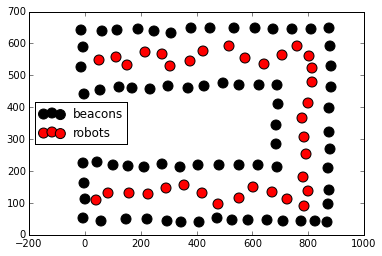

In [6]:
mat_contents = sio.loadmat('task2.mat')
rn = RoboticNavigation2(mat_contents)
sol = rn.levenberg_marquardt()
rn.visualize(sol, loc='center left')

** Experiment three (task3.mat) - 6 points: **  This is another complex environment. On top of the complications from the previous experiment, your robot beacon identification system is now working imperfectly, so that every so often (say, in 3% cases), the robot would confuse the number of the beacon that it observes. You have to make your reconstruction algorithm robust to such mistakes.  Instruction: use non-linear optimization *scipy.optimize* in python (you get 2 points for any implementation that produces an accurate reconstruction). You are recommended to supply it with an analytically-computed gradient (+2 points). Use the option 'method=BFGS' to make python to use a quasi-Newton BFGS method, play with the number of iterations that are allowed ('options.maxiter') to see the effect; you can also try to provide the algorithm with the Hessian derived analytically. You get +2 points if your approach devised this way will work faster or comparable with quasi-Newton. 

**Output.** For each experiment, your pdf file should include:
*	A printout of the reconstruction: use e.g. scatter plots with different colors used for beacons and robots positions.
*	An explanation of what you have tried and what you have observed.
Of course, your code should be attached.


### Solution

In this case we use the following loss function: $L(F) = \sum_{i=1}^{2N} H(F_i)$, where $H$ is Huber loss. This function is not sensitive to rare ejections and provides robust solution of our problem.

We computed analytically gradient of this function (look at **gradient**) and gave it to BFGS-method of **scipy.optimize** to obtain solution.

In [7]:
class RoboticNavigation3(RoboticNavigation2):
    
    def __init__(self, mat_contents):
        super(RoboticNavigation3, self).__init__(mat_contents)
        
    def loss_function(self, X):
        """Calculate total loss function as sum of Huber loss functions."""
        
        F = self.vector_function(X)  
        return huber(0.5, F).sum()

    def gradient(self, X):
        """Calculate gradient of loss function -- sum of hubers."""
        
        beacons, robots, x, y, B, R, N = self.beacons, self.robots, self.x, self.y, self.B, self.R, self.N
        
        F = self.vector_function(X)
        grad = np.zeros(2*B+3*R)
        
        d = np.clip(F, -0.5, 0.5)
        
        for i in xrange(N):
            theta = X[2*B+2*R+robots[i]]

            grad[beacons[i]] += d[i]
            grad[B+robots[i]] -= d[i]
            grad[2*B+2*R+robots[i]] += d[i]*(x[i]*np.sin(theta) + y[i]*np.cos(theta))

            grad[B+R+beacons[i]] += d[N+i]
            grad[2*B+R+robots[i]] -= d[N+i]
            grad[2*B+2*R+robots[i]] += d[N+i]*(-x[i]*np.cos(theta) + y[i]*np.sin(theta))

        return grad     
    
    def hessian(self, X):
        """Calculate hessian of loss function."""
        
        beacons, robots, x, y, B, R, N = self.beacons, self.robots, self.x, self.y, self.B, self.R, self.N
        
        H = np.zeros((2*B+3*R, 2*B+3*R)) 
        F = self.vector_function(X)
        
        for i in xrange(N):
            
            theta = X[2*B+2*R+robots[i]]
            
            d = np.clip(F[i], -0.5, 0.5) 
            if (np.abs(d) == 0.5):
                H[2*B+2*R+robots[i]][2*B+2*R+robots[i]] += (d/2)*(x[i]*np.cos(theta) - y[i]*np.sin(theta))
            else:
                H[beacons[i]][beacons[i]] += 0.5
                H[beacons[i]][B+robots[i]] += -1
                H[beacons[i]][2*B+2*R+robots[i]] += x[i]*np.sin(theta) + y[i]*np.cos(theta)
                H[B+robots[i]][B+robots[i]] += 0.5
                H[B+robots[i]][2*B+2*R+robots[i]] += -x[i]*np.sin(theta) - y[i]*np.cos(theta)
                H[2*B+2*R+robots[i]][2*B+2*R+robots[i]] += ((y[i]**2-x[i]**2)*np.cos(2*theta) + 2*x[i]*y[i]*np.sin(2*theta))/2
                
            d = np.clip(F[N+i], -0.5, 0.5)
            if (np.abs(d) == 0.5):
                H[2*B+2*R+robots[i]][2*B+2*R+robots[i]] = (d/2)*(x[i]*np.sin(theta) + y[i]*np.cos(theta))
            else:
                H[B+R+beacons[i]][B+R+beacons[i]] += 0.5
                H[B+R+beacons[i]][2*B+R+robots[i]] += -1
                H[B+R+beacons[i]][2*B+2*R+robots[i]] += -x[i]*np.cos(theta) + y[i]*np.sin(theta)
                H[2*B+R+robots[i]][2*B+R+robots[i]] += 0.5
                H[2*B+R+robots[i]][2*B+2*R+robots[i]] += x[i]*np.cos(theta) - y[i]*np.sin(theta)
                H[2*B+2*R+robots[i]][2*B+2*R+robots[i]] += ((x[i]**2-y[i]**2)*np.cos(2*theta) - 2*x[i]*y[i]*np.sin(2*theta))/2

        return H+H.T
        
    def robust_reconstruct(self):
        """Reconstruct beacons and robot positions when robot beacon identification system is now working imperfectly."""
        
        beacons, robots, x, y, B, R, N = self.beacons, self.robots, self.x, self.y, self.B, self.R, self.N
        
        sol = self.simple_reconstruct()
        init = np.concatenate(sol)

        X = minimize(self.loss_function, init, method='BFGS', jac=self.gradient).x   
        
        X_beacons = X[:B]
        Y_beacons = X[B+R:2*B+R]
        X_robots = X[B:B+R]
        Y_robots = X[2*B+R:2*B+2*R]
        Thetas = X[2*B+2*R:]

        return X_beacons, X_robots, Y_beacons, Y_robots, Thetas

    def hessian_solve(self):
        """Solve problem with hessian."""
        
        beacons, robots, x, y, B, R, N = self.beacons, self.robots, self.x, self.y, self.B, self.R, self.N
        
        sol = self.simple_reconstruct()
        init = np.concatenate(sol)
        
        X = minimize(self.loss_function, init, method='trust-ncg', jac=self.gradient, hess=self.hessian).x 
        
        X_beacons = X[:B]
        Y_beacons = X[B+R:2*B+R]
        X_robots = X[B:B+R]
        Y_robots = X[2*B+R:2*B+2*R]
        Thetas = X[2*B+2*R:]

        return X_beacons, X_robots, Y_beacons, Y_robots, Thetas

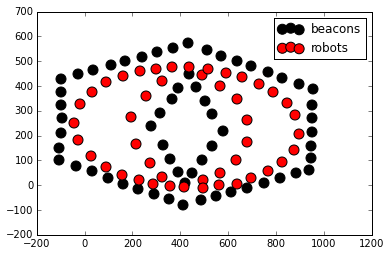

In [8]:
mat_contents = sio.loadmat('task3.mat')
rn = RoboticNavigation3(mat_contents)
sol = rn.robust_reconstruct()
rn.visualize(sol)